In [1]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load pretrained models
load_pretrained_models = True
# number of epochs of training
n_epochs = 15
# size of the batches
batch_size = 16
# name of the dataset
#dataset_name = "../input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset_name = '/content/drive/MyDrive/OSAIL_Data/Unlabeled'
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 4
# dimensionality of the latent space
latent_dim = 100
# size of each image dimension
img_size = 128
# size of random mask
mask_size = 64
# number of image channels
channels = 1
# interval between image sampling
sample_interval = 500

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.png" % root))
        #self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

In [6]:
transforms_ = [
    transforms.Resize((img_size, img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
]
train_dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)
test_dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_, mode="val"),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)

Here is an example of the the preprocessed images:

<Figure size 800x800 with 0 Axes>

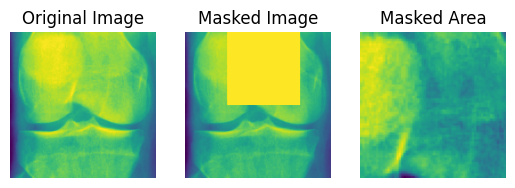

In [70]:
imgs, masked_imgs, masked_parts = next(iter(train_dataloader))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 1
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3)

# use the created array to output your multiple images
axarr[0].imshow(imgs[0].squeeze())
axarr[0].set_title('Original Image')
axarr[0].axis('off')
axarr[1].imshow(masked_imgs[0].squeeze())
axarr[1].set_title('Masked Image')
axarr[1].axis('off')
axarr[2].imshow(masked_parts[0].squeeze())
axarr[2].set_title('Masked Area')
axarr[2].axis('off');